<img src="https://www.th-ab.de/typo3conf/ext/th_ab/Resources/Public/assets/logo-th-ab.svg" alt="TH-AB Logo" width="200"/>

Prof. Dr. Möckel, Prof. Dr. Radke, Katharina Kuhnert

Maschinelles Lernen Schwerpunkt Data Science<br>
SoSe 2024

# Vorlesung 7: Convolutional Neural Networks (CNN) in PyTorch

### Bibliotheken importieren und PyTorch Umgebung prüfen

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# PyTorch
try:
    import torch
    import torchvision
    import torchmetrics
except:
    !pip install torch
    !pip install torchvision
    !pip install torchmetrics
    import torch
    import torchvision
    import torchmetrics

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# PyTorch Version überprüfen
if (torch.__version__ < "2.0.0"):
    raise Exception("Wrong PyTorch version")
else:
    print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.0.0+cu118


### Datasets aus MNIST laden und für maschinelles Lernen in Teildatensätze aufteilen 
* Training dataset
* Non-training dataset (Validierung und Test)

In [ ]:
# Dataset für Training
ds_train = datasets.MNIST(
    root="data", # Zielpfad für Datendownload
    train=True, # Trainingsdaten laden
    download=True,
    transform=ToTensor(), # Transformiere Features (Bilddaten) zu Tensoren
    target_transform=None # Keine Transformierung für Labels (Targets)
)

# Dataset für Validierung und Test
ds_non_train = datasets.MNIST(
    root="data",
    train=False, # Keine Trainingsdaten laden
    download=True,
    transform=ToTensor()
)

# Splitting des non-train Dataset in:
# 80% für Validierung (Modellvalidierung)
# 20% für Tests
total_count = len(ds_non_train)
valid_count = int(0.5 * total_count) 
test_count = int(0.5 * total_count)

# Splitte non-Train Dataset
ds_valid, ds_test = torch.utils.data.random_split(ds_non_train, (valid_count, test_count))

### Initiierung der DataLoader

Das schrittweise Laden der Daten aus dem Datensatz in Abschnitten (batches) wird durch Datenloader realisiert. 

In [ ]:
from torch.utils.data import DataLoader

# Nutze eine Batch-größe von 32
BATCH_SIZE = 32

# Die DataLoader Klasse ermöglicht die Iteration durch die
# Features eines Datasets.
train_dataloader = DataLoader(ds_train,
    batch_size=BATCH_SIZE,

    # Zufällige Auswahl für jedes Batch
    shuffle=True
)

# DataLoader für Validierung
valid_dataloader = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True) 

# DataLoader für Tests
test_dataloader = DataLoader(ds_test , batch_size=BATCH_SIZE, shuffle=False)

# Ausgabe der Dataloader
print("Größe train_dataloader:", len(train_dataloader), "Batches aus", BATCH_SIZE)
print("Größe valid_dataloader:", len(valid_dataloader), "Batches aus", BATCH_SIZE)
print("Größe test_dataloader:", len(test_dataloader), "Batches aus", BATCH_SIZE)

Größe train_dataloader: 1875 Batches aus 32
Größe valid_dataloader: 157 Batches aus 32
Größe test_dataloader: 157 Batches aus 32


Da das Dataset für die Klassifikation von Ziffern gedacht ist entsprechen die Labels die Bezeichnungen der jeweiligen Ziffern. Die Klassen des Datasets lassen sich über das Property `.classes` ermitteln:

In [ ]:
# Lade beliebiges Image aus Trainingsdataset
image, label = ds_train[0]

# Bestimme Datenformat
image_size = image.shape[0]

# Lade Klassenbezeichnungen
class_names = ds_train.classes

# Convolutional Neural Networks (CNN) 

## Definition der Faltung:

Eine Faltung (engl. convolution) ist eine Integraltransformation

$$ (f * g )(t) = \int_{-\infty}^{\infty} f(\tau) g(t-\tau) d\tau $$

Typischerweise wird ein Signal (hier z.B. g(t)) mit einer Filter- oder Gewichtsfunktion (hier z.B. f(t), engl. kernel ) im gesamten Definitionsbereich gefalten. 

Die Faltung ist symmetrisch, Vertauschung von f und g bewirkt keine Änderung 

$$ (f * g )(t) = ( g * f ) (t) $$
(Beweis über partielle Integration mit verschwindenden Randtermen)

## Faltung auf Matrizen:

Eine Faltung kann auf diskreten Matrizen durch geeignete Summierungen dargestellt werden. Dies ist in sog. convolutional layers realisiert. 

Sie dienen (durch die Summierungsvorschrift) zur Reduzierung des Datenumfangs, d.h. die Zahl der Input-Werte ist typischerweise größer als die Zahl der Output-Werte

Ein Beispiel `nn.Conv2d()` mit verschiedenen Parametern:
* `in_channels` (int) - Number of channels in the input image.
* `out_channels` (int) - Number of channels produced by the convolution.
* `kernel_size` (int or tuple) - Size of the convolving kernel/filter.
* `stride` (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* `padding` (int, tuple, str) - Padding added to all four sides of input. Default: 0.

![example of going through the different parameters of a Conv2d layer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv2d-layer.gif)

*Beispiel bei Änderung der Hyperparameter eines `nn.Conv2d()` layer.*

Quelle: https://github.com/mrdbourke/pytorch-deep-learning

## Aufbau von CNNs aus Abfolge von Blockstrukturen:

CNNs bestehen aus zwei Teilabschnitten: 

(1) __Feature extraction:__

Faltungen der eingehenden Bilder, die die Nachbarschaftsbeziehungen von Pixeln berücksichtigen. Eingegeben werden daher Matrizen. Durch Reduktionen (trainierbare Filtermatrizen) entstehen Features von reduziertem Umfang

(2) __Klassifikation:__

Nachdem geeignete features gebildet wurden dienen diese als Ausgangspunkt für die Klassifikation mit vollständig vermaschten Schichten

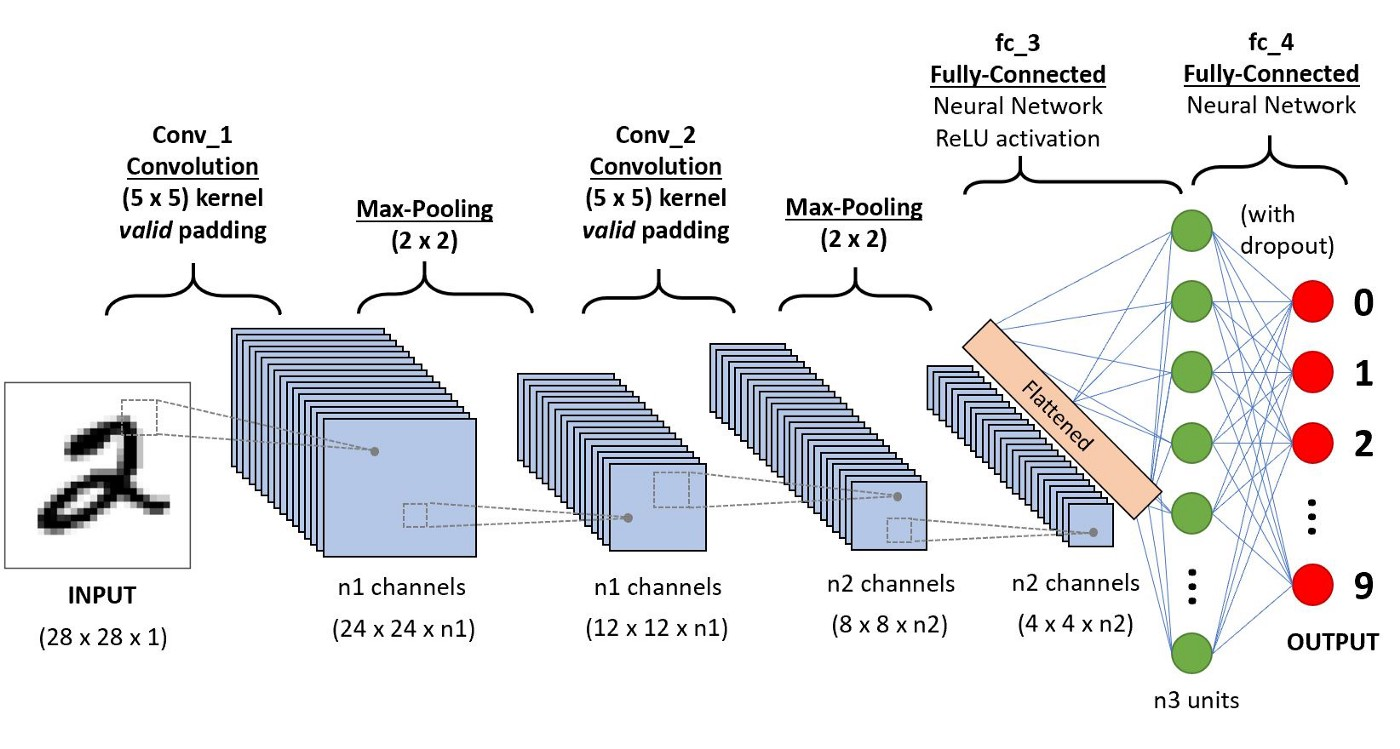

Reduktion von Bildgrößen geschieht durch __Pooling__. __MaxPooling__ weist dabei dem Ergebnis den in einem Block vorgegebener Größe auftretenden maximalen Wert zu 

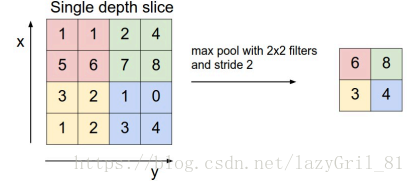

Verschiedene Filter können nacheinander unterschiedliche Merkmale extrahieren:

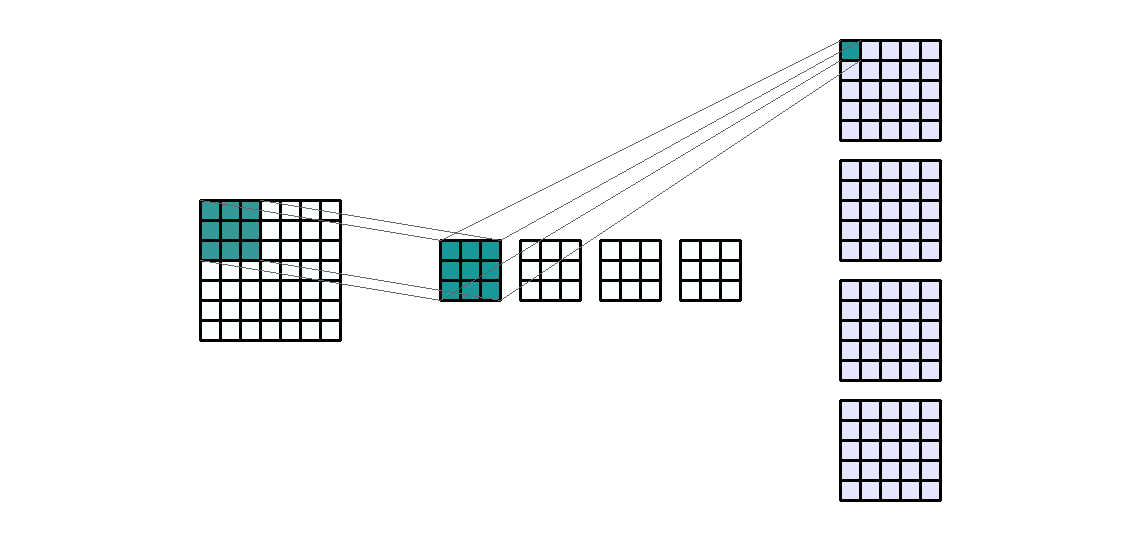

Quelle: https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148

Hier: Input Shape: (3, 7, 7) — Output Shape : (4, 5, 5) — 

Vier verschiedene Kernels der Größe K : (3, 3) — P : (0, 0) — S : (1, 1) 

Weitere Parameter: 

- Dilation (Abstand zwischen Kernelelementen, default) — D : (1, 1) 
- Groups (Gruppierungen, default) — G : 1

## Einfaches CNN Modell:

#### Definition der Blockstruktur als Klasse:

In [ ]:
# Definiere CNN Modell
class CNN_model(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        # Konstruktor der Basisklasse aufrufen
        super().__init__()

        # (1) Feature extraction:

        # Konstruiere 1. Block (Input Conv2d -> ReLU -> Hidden Conv2d -> ReLU -> MaxPool2d)
        self.block_1 = nn.Sequential(
            # Schritt 1: Verknüpfung von Inputs und der Hidden Layer
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                # Größe des convolving Kernels
                kernel_size=3,
                # Schrittweite
                stride=1,
                # Padding für Input festlegen
                padding=1
            ),
            # Schritt 2: ReLU Aktivierungsfunktion
            nn.ReLU(),
            # Schritt 3: Verknüpfung Hidden Layer
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            # Schritt 4: ReLU Aktivierungsfunktion
            nn.ReLU(),
            # Schritt 5: Reduktion
            # Max-Pooling reduziert die Dimensionalität von Bildern, 
            # indem die Anzahl der Pixel in der Ausgabe der vorherigen 
            # Faltungsschicht reduziert wird.
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Konstruiere 2. Block (Hidden Conv2d -> ReLU -> Hidden Conv2d -> ReLU -> MaxPool2d)
        self.block_2 = nn.Sequential(
            # Schritt 1: Verknüpfung Hidden Layer
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            # Schritt 2: ReLU Aktivierungsfunktion
            nn.ReLU(),
            # Schritt 3: Verknüpfung Hidden Layer
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            # Schritt 4: ReLU Aktivierungsfunktion
            nn.ReLU(),
            # Schritt 5: Reduktion
            nn.MaxPool2d(2)
        )

        # (2) Klassifizierer 
        self.classifier = nn.Sequential(
            # Schritt 1: Umwandeln in Vektor
            nn.Flatten(),
            # Schritt 2: Verknüpfen von Hidden Layers mit Output
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x):
        # Durchlaufe Block 1
        x = self.block_1(x)
        # Durchlaufe Block 2
        x = self.block_2(x)
        # Durchlaufe Klassifizierer
        x = self.classifier(x)

        return x

##### Definition eines konkreten CNN-Modells als Objekt:

Festlegung der freien Parameter der Topologie

In [ ]:
torch.manual_seed(42)

# Erzeuge konkretes CNN Modell über Angabe der Parameter
model_0 = CNN_model(
    # Input ist Feature (Bild) mit n x m Pixeln Größe
    input_shape = image_size*image_size,

    # Erzeuge 12 Neuronen im Hidden Layer
    hidden_units = 12,

    # Output-Layer des NN hat für jeden Klassenname ein Neuron
    output_shape = len(class_names)
)

# Weise dem Modell die CPU zu.
model_0.to("cpu")


CNN_model(
  (block_1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=588, out_features=10, bias=True)
  )
)

#### Auswahl der Fehler- (Loss) bzw. Kostenfunktion (Cost) 

Verwendung der Kreuzentropie

In [ ]:
# Verwende Cross Entropy als Loss Funktion
loss_fn = nn.CrossEntropyLoss()

#### Auswahl des Optimierers 

Angabe der den Optimierer betreffenden Hyperparameter

In [ ]:
# Hyperparameter Lernrate
LEARN_RATE = 0.1

# Nutze Stochastic Gradient Descent als Optimierfunktion
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARN_RATE)

## Training des CNNs 

**Hinweis:** Training benötigt mehr als 4 GiB Speicher! Laufzeit mit 5 Epochen ~4 Minuten

In [ ]:
# Initiierung der trainierbaren Parameter durch Zufallszahlen
torch.manual_seed(42)

# Hyperparameter Zahl der Epochen
EPOCHS = 5

# Merke Trainingfehler jeder Epoche für Plotting
t_loss = []

for epoch in range(EPOCHS):
    print("Epoch:", epoch, end="\n-------\n")

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):

        # Initiiere Modell in den Trainingsmodus (kein Training! Nur Modus setzen.)
        model_0.train() 

        # NN 1. Anwendung des Modells auf Feature
        y_pred = model_0(X)

        # NN 2. Berechne loss für die aktuelle Batch
        loss = loss_fn(y_pred, y)

        # Merke Training loss über die aktuelle Epoche
        train_loss += loss

        # NN 3. Initiiere Optimizer Gradients auf 0
        optimizer.zero_grad()

        # NN 4. Initiiere Rückwärtspropagation des Fehlers
        loss.backward()

        # NN 5. Optimiere
        # Veränderung der Gewichte im Neuronalen Netz durch Zuweisung von Anteilen des Gesamtfehlers
        optimizer.step()

        # Ausgabe der bisher verarbeiteten Samples (Bild + Label)
        if batch % 400 == 0:
            print("Samples verarbeitet:", batch * len(X), "/", len(train_dataloader.dataset))

    # Ausgabe des durchschnittlichen Fehlers
    train_loss /= len(train_dataloader)

    # Speichere Trainingfehler
    t_loss.append(train_loss)

    print("Trainingsfehler: {:.5f}".format(train_loss))

Epoch: 0
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 0.28298
Epoch: 1
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 0.06848
Epoch: 2
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 0.05406
Epoch: 3
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 0.04623
Epoch: 4
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 6

### Darstellung des Fehlers auf den Trainingsdaten

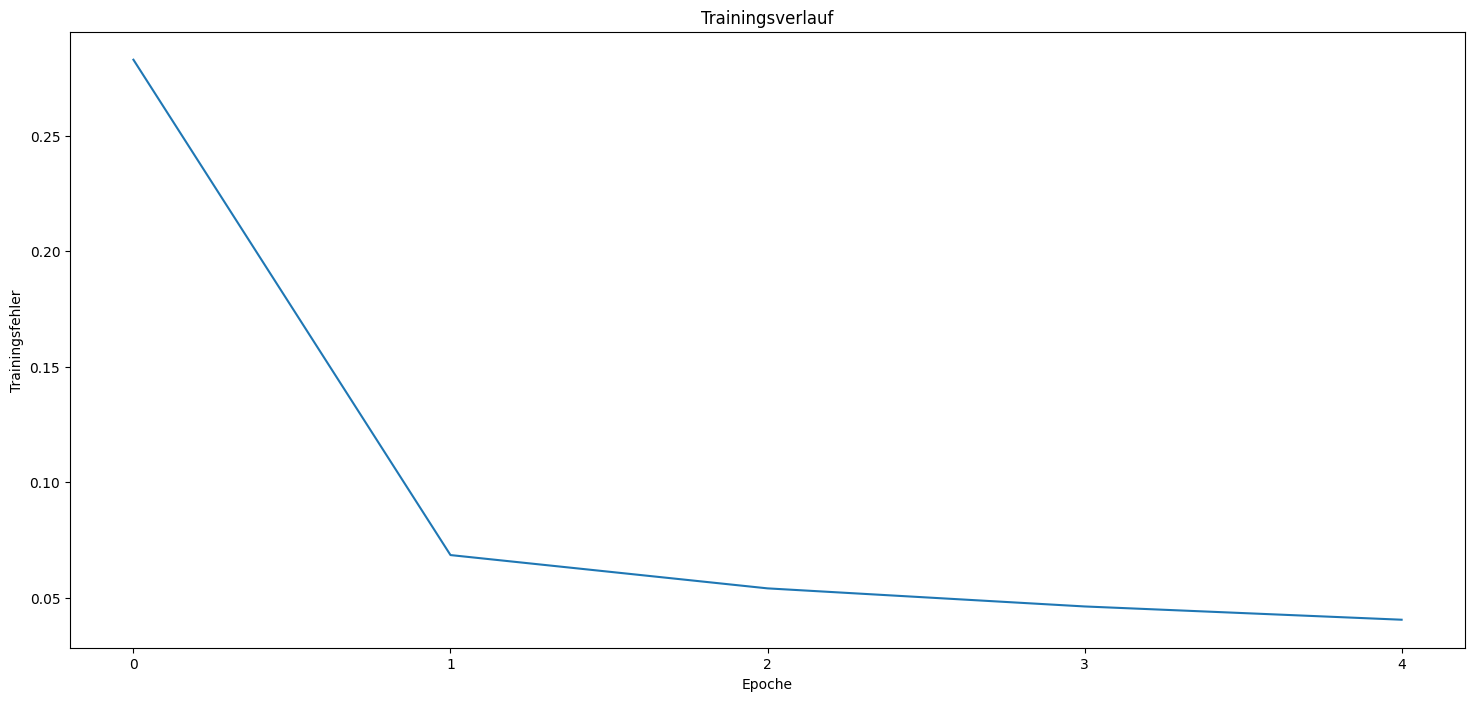

In [ ]:
# Lambda um Liste aus Tensoren in Liste aus Float umzuwandeln
y_loss = lambda b : [x.tolist() for x in b]

# Lambda um y-Werte für Plot zu erzeugen
x_loss = lambda b : [ x for x in range(0, b)]

plt.figure(figsize=(18, 8))
plt.plot(x_loss(EPOCHS), y_loss(t_loss))
plt.xlabel("Epoche")
plt.ylabel("Trainingsfehler")
plt.title("Trainingsverlauf")
plt.xticks(x_loss(EPOCHS))
plt.show()


## Beurteilung des Trainingserfolgs __Confusion matrix__:

In [ ]:
y_test = []
y_pred = []

# Abschalten der Gradientenberechnung (nicht notwendig bei Evaluation)
with torch.no_grad():
    # Umschalten vom Training- in den Evaluationsmodus
    # Alternative: model_0.train(False) 
    model_0.eval()

    # loop for each data
    for X,y in test_dataloader:
        # STEP 1: forward pass
        output = model_0(X)
        # STEP 2: get predicted label
        _, pred_label = torch.max(output, dim=1)
        # STEP 3: append actual and predicted label
        y_test += y.numpy().tolist()
        y_pred += pred_label.numpy().tolist()

In [ ]:
print(y_test)
print(y_pred)

[4, 7, 0, 6, 0, 6, 4, 7, 0, 1, 3, 9, 3, 1, 4, 0, 5, 9, 9, 7, 6, 9, 1, 1, 0, 1, 1, 9, 2, 5, 0, 9, 1, 6, 8, 3, 6, 9, 9, 6, 9, 6, 2, 5, 3, 4, 6, 9, 0, 7, 8, 1, 8, 2, 0, 2, 3, 8, 2, 0, 2, 9, 5, 4, 4, 4, 0, 8, 2, 6, 8, 5, 2, 0, 8, 2, 0, 2, 2, 5, 3, 7, 7, 9, 1, 4, 0, 2, 5, 7, 1, 7, 8, 2, 5, 3, 0, 7, 1, 6, 9, 3, 9, 4, 7, 3, 6, 2, 6, 2, 5, 6, 6, 3, 6, 4, 4, 3, 0, 8, 1, 2, 1, 9, 3, 9, 6, 0, 3, 2, 3, 2, 2, 5, 2, 8, 1, 9, 7, 0, 7, 8, 3, 2, 4, 0, 9, 3, 1, 7, 7, 5, 8, 3, 7, 8, 8, 5, 0, 7, 4, 0, 3, 2, 0, 1, 9, 8, 5, 6, 3, 4, 7, 4, 7, 1, 6, 4, 7, 3, 4, 4, 3, 9, 7, 8, 4, 6, 5, 4, 5, 5, 0, 5, 9, 5, 2, 0, 0, 5, 3, 8, 9, 9, 5, 5, 0, 3, 4, 9, 4, 3, 2, 5, 0, 3, 9, 2, 7, 4, 0, 3, 5, 8, 8, 1, 2, 5, 4, 2, 8, 4, 3, 5, 2, 1, 3, 9, 8, 6, 9, 0, 1, 1, 4, 3, 3, 3, 1, 9, 2, 7, 0, 2, 9, 7, 8, 2, 2, 4, 7, 9, 3, 5, 4, 4, 3, 0, 5, 9, 2, 1, 7, 9, 7, 9, 2, 5, 2, 1, 9, 3, 9, 8, 9, 7, 3, 1, 6, 9, 0, 1, 2, 4, 5, 0, 9, 1, 2, 5, 4, 5, 6, 2, 4, 3, 9, 6, 5, 6, 1, 1, 7, 8, 3, 0, 1, 0, 0, 6, 7, 2, 1, 1, 1, 1, 9, 0, 1, 2, 1, 3, 5, 

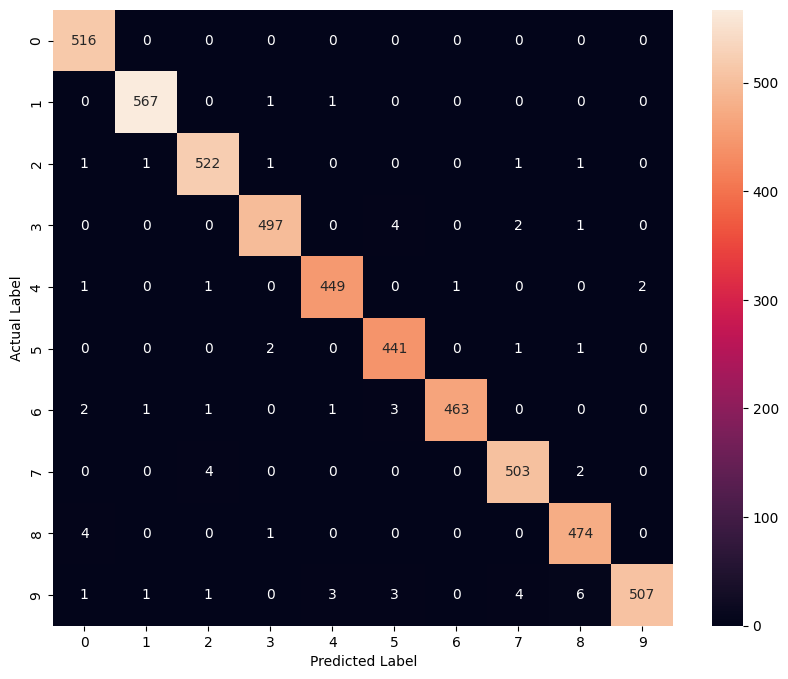

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

Aggregierte Fehlermetriken für einzelne Klassen:

In [ ]:
from sklearn.metrics import classification_report, auc, roc_curve
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       516
           1       0.99      1.00      1.00       569
           2       0.99      0.99      0.99       527
           3       0.99      0.99      0.99       504
           4       0.99      0.99      0.99       454
           5       0.98      0.99      0.98       445
           6       1.00      0.98      0.99       471
           7       0.98      0.99      0.99       509
           8       0.98      0.99      0.98       479
           9       1.00      0.96      0.98       526

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

